In [1]:
import jax
import jax.numpy as jnp
from tqdm import tqdm
import seaborn as sns

sns.set(style="whitegrid")

In [62]:
@jax.jit
def beale(theta: jnp.DeviceArray) -> jnp.DeviceArray:
  x = jnp.dot(theta, jnp.array([1., 0.]))
  y = jnp.dot(theta, jnp.array([0., 1.]))
  xy = jnp.dot(x, y)
  xyy = jnp.dot(xy, y)
  xyyy = jnp.dot(xyy, y)
  return jnp.power(1.5 - x + xy, 2) + jnp.power(2.25 - x + xyy, 2) + jnp.power(2.625 - x + xyyy, 2)

@jax.jit
def rosenbrock(theta: jnp.DeviceArray) -> jnp.DeviceArray:
  x = jnp.dot(theta, jnp.array([1., 0.]))
  y = jnp.dot(theta, jnp.array([0., 1.]))
  return jnp.power(1 - x, 2) + 100 * jnp.power(y - x * x, 2)

class SGD(object):

  def __init__(self, params, momentum=0, dampening=0, eta=1e-3, nestereov=False):
    self.shape = params.shape
    self.momentum = momentum
    self.dampening = dampening
    self.eta = eta
    self.nesterov = nestereov
    self.prev_grad = None
    self.t = 0

  def update(self, params, key, loss):
    v = jax.random.normal(key, shape=self.shape)
    _, dd = jax.jvp(loss, (params,), (v,))
    grad = dd * v

    if self.momentum != 0:
      if self.t == 0:
        self.b = grad
      else:
        self.b = self.momentum * self.b + (1 - self.dampening) * grad
      
      if self.nesterov and self.t > 0:
        grad = self.prev_grad + self.momentum * self.b
      else:
        grad = self.b

    self.prev_grad = grad
    self.t += 1

    return params - self.eta * grad


In [88]:
theta = jnp.array([0., 0.5])
xs = []
ys = []
f_val = []

optim = SGD(theta, momentum=0.75, eta=0.01, dampening=0.9)

for i in tqdm(range(1000)):
    theta = optim.update(theta, jax.random.PRNGKey(i), beale)
    xs.append(float(theta[0]))
    ys.append(float(theta[1]))
    f_val.append(float(beale(theta)))

100%|██████████| 1000/1000 [00:03<00:00, 321.64it/s]


In [64]:
theta = jnp.array([0., 0.5])
xs_1 = []
ys_1 = []
f_val_1 = []

optim = SGD(theta, eta=0.01)

for i in tqdm(range(1000)):
    theta = optim.update(theta, jax.random.PRNGKey(i), beale)
    xs_1.append(float(theta[0]))
    ys_1.append(float(theta[1]))
    f_val_1.append(float(beale(theta)))

100%|██████████| 1000/1000 [00:03<00:00, 264.23it/s]


Text(0.5, 1.0, 'Params')

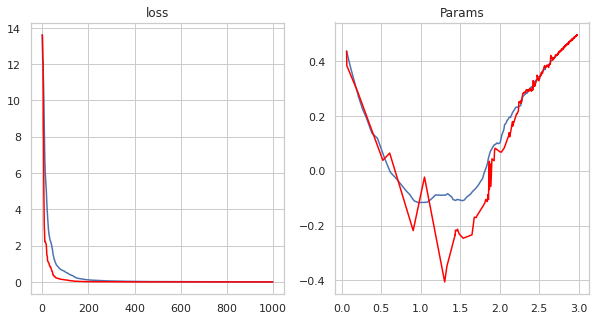

In [89]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=[i for i in range(len(f_val))], y=f_val, ax=ax[0])
sns.lineplot(x=[i for i in range(len(f_val_1))], y=f_val_1, ax=ax[0], color='red')
# add title : loss
ax[0].set_title('loss')
sns.lineplot(x=xs, y=ys, ax=ax[1])
sns.lineplot(x=xs_1, y=ys_1, ax=ax[1], color='red')
ax[1].set_title('Params')